In [1]:
# Purpose:
# To predict driver gender based on information about hit & run accident

In [2]:
# Imports and options

import pandas as pd
import numpy as np
import pickle

pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

%matplotlib inline

/Users/maludee/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Import the cleaned traffic datafile - includes only hit and runs
with open("hit_run.pkl", 'rb') as picklefile:
    hit_run = pickle.load(picklefile)
    
hit_run.head()

,hit_run,drunk_dr_1,drugs_1.0,"age_(20, 65]","age_(65, 120]",ve_total_2,ve_total_3,ve_total_4,ve_total_5,peds_1,permvit_2,permvit_3,permvit_4,permvit_5,fatals_1,deaths_1,month_spring,month_summer,month_winter,day_week_weekend,hour_nighttime,nhs_1.0,rur_urb_2.0,rur_urb_6.0,harm_ev_inanimate,harm_ev_ped or cyclist,harm_ev_train,harm_ev_vehicle,man_coll_1.0,man_coll_2.0,man_coll_6.0,man_coll_7.0,man_coll_8.0,man_coll_9.0,man_coll_10.0,man_coll_11.0,weather_good,body_typ_bus,body_typ_car,body_typ_convertible,body_typ_motorcycle,body_typ_other,body_typ_pickup truck,body_typ_van or SUV,haz_inv_2,fire_exp_1,l_status_valid,cdl_stat_valid,l_restri_1.0,l_restri_2.0,l_restri_3.0,prev_acc_1.0,prev_sus_1.0,prev_dwi_1.0,prev_spd_1.0,prev_oth_1.0,speedrel_speeding,vsurcond_dry,vsurcond_wet,vtcont_f_1.0,vtcont_f_2.0,vtcont_f_3.0,sex_2.0,inj_sev_serious,rest_mis_1
59,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
65,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
164,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
216,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
234,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
# Drop columns that wouldn't be known if the driver was missing
hit_run = hit_run.drop('l_status_valid', 1)
hit_run = hit_run.drop('cdl_stat_valid', 1)
hit_run = hit_run.drop('l_restri_1.0', 1)
hit_run = hit_run.drop('l_restri_2.0', 1)
hit_run = hit_run.drop('l_restri_3.0', 1)
hit_run = hit_run.drop('prev_acc_1.0', 1)
hit_run = hit_run.drop('prev_sus_1.0', 1)
hit_run = hit_run.drop('prev_dwi_1.0', 1)
hit_run = hit_run.drop('prev_spd_1.0', 1)
hit_run = hit_run.drop('prev_oth_1.0', 1)


In [5]:
# Move gender to first column for simplicity
cols = list(hit_run)
cols.insert(0, cols.pop(cols.index('sex_2.0')))
hit_run = hit_run.ix[:, cols]
hit_run.head(3)

,sex_2.0,hit_run,drunk_dr_1,drugs_1.0,"age_(20, 65]","age_(65, 120]",ve_total_2,ve_total_3,ve_total_4,ve_total_5,peds_1,permvit_2,permvit_3,permvit_4,permvit_5,fatals_1,deaths_1,month_spring,month_summer,month_winter,day_week_weekend,hour_nighttime,nhs_1.0,rur_urb_2.0,rur_urb_6.0,harm_ev_inanimate,harm_ev_ped or cyclist,harm_ev_train,harm_ev_vehicle,man_coll_1.0,man_coll_2.0,man_coll_6.0,man_coll_7.0,man_coll_8.0,man_coll_9.0,man_coll_10.0,man_coll_11.0,weather_good,body_typ_bus,body_typ_car,body_typ_convertible,body_typ_motorcycle,body_typ_other,body_typ_pickup truck,body_typ_van or SUV,haz_inv_2,fire_exp_1,speedrel_speeding,vsurcond_dry,vsurcond_wet,vtcont_f_1.0,vtcont_f_2.0,vtcont_f_3.0,inj_sev_serious,rest_mis_1
59,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
65,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
164,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [6]:
# Rename gender column for clarity
hit_run.rename(columns={'sex_2.0':'female'}, inplace=True)
hit_run.female.value_counts()

0.00    257
1.00     60
Name: female, dtype: int64

In [7]:
# set x and y and test train split for whole dataset
y = hit_run.ix[:,0]
X = hit_run.ix[:,5:]

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444, stratify=y)

In [8]:
# Oversample females to balance classes
train_data = pd.concat([X_train, y_train], axis=1, join='inner')
females = train_data.loc[train_data['female'] == 1]
males = train_data.loc[train_data['female'] == 0]

for i in range(20):
    males = males.append(females)

males.female.value_counts()

1.00    840
0.00    179
Name: female, dtype: int64

In [9]:
# Set x and y train
y_train = males['female']
X_train = males.drop(['female'], axis = 1)

In [10]:
# Fit the model & print out score
log_model = LogisticRegression(class_weight='balanced', penalty='l1', C=10)
result = log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
test_score = log_model.score(X_test, y_test)
train_score = log_model.score(X_train, y_train)

print "log model:", train_score, test_score
print "precision:", precision_score(y_pred, y_test)
print "recall:", recall_score(y_pred, y_test)
print "F1:", f1_score(y_pred, y_test)


coefficients = zip(X.columns, log_model.coef_[0])
sorted(coefficients, key = lambda x: x[1], reverse = True)


log model: 0.827281648675 0.739583333333
precision: 0.666666666667
recall: 0.387096774194
F1: 0.489795918367


[(u'body_typ_van or SUV', 5.6850648580432281),
 (u'body_typ_car', 5.4982180338413524),
 (u'man_coll_1.0', 5.385447380925795),
 (u'body_typ_pickup truck', 4.4745885277412851),
 (u'vsurcond_wet', 4.4389372865721386),
 (u'man_coll_2.0', 4.2957899627250278),
 (u'vsurcond_dry', 4.1874410570794218),
 (u'inj_sev_serious', 3.4645932771361378),
 (u'man_coll_6.0', 3.3408325237140386),
 (u'fatals_1', 2.0481234074228141),
 (u've_total_5', 1.5898280971166427),
 (u've_total_4', 1.3322237313880727),
 (u'nhs_1.0', 1.2763879453419964),
 (u've_total_2', 1.0388687532325009),
 (u'permvit_4', 0.569037701552214),
 (u'deaths_1', 0.42144926009776706),
 (u'month_spring', 0.19708560561517657),
 (u'harm_ev_ped or cyclist', 0.0),
 (u'harm_ev_train', 0.0),
 (u'man_coll_8.0', 0.0),
 (u'man_coll_9.0', 0.0),
 (u'man_coll_10.0', 0.0),
 (u'man_coll_11.0', 0.0),
 (u'body_typ_bus', 0.0),
 (u'body_typ_convertible', 0.0),
 (u'haz_inv_2', 0.0),
 (u'vtcont_f_2.0', 0.0),
 (u'rest_mis_1', 0.0),
 (u'fire_exp_1', -0.010307338875

Confusion matrix, without normalization
[[59 19]
 [ 6 12]]
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.33  0.67]]


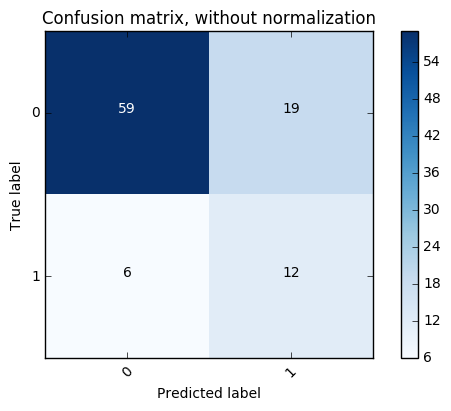

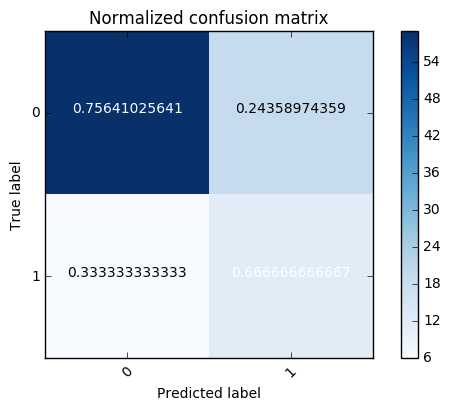

In [11]:
# Plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [12]:
# Random Forest
forest_model = RandomForestClassifier()
result = forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)
test = forest_model.score(X_test, y_test)
train = forest_model.score(X_train, y_train)
print "Random forest:", train, test

print "precision:", precision_score(y_pred, y_test)
print "recall:", recall_score(y_pred, y_test)
print "F1:", f1_score(y_pred, y_test)


# features = zip(X.columns, forest_model.feature_importances_)
# sorted(features, key = lambda x: x[1], reverse = True)

Random forest: 0.990186457311 0.770833333333
precision: 0.277777777778
recall: 0.357142857143
F1: 0.3125


Optimal number of features : 19


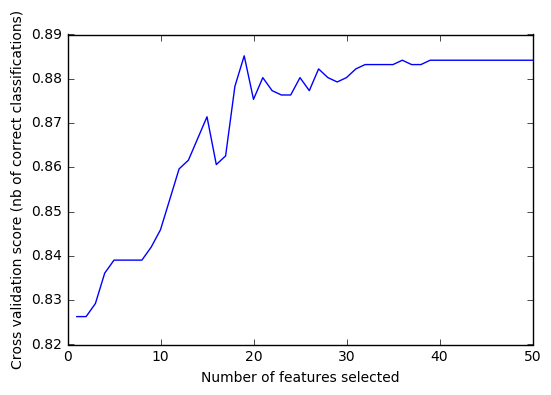

In [13]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
